# Mini Lab: SVM and Logistic Regression Modeling

### Teammates: Chad Kwong, Erin McClure-Price, Alex Lopez, Chris Haub

## Initial loading of dataset and all related packages

The first step was to load necessary packages and the dataset. In addition, we created a series of variables for indexing both the continuous and categorical variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
import glob
import os
import seaborn as sns
from matplotlib.pyplot import figure



#Suppress futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Set Figure Size
plt.rcParams["figure.figsize"] = (20,10)

#Import Dataset from github repo
bankData = pd.read_csv('bank-additional-full.csv', sep=';', na_values="unknown")
#Optional: Add in index column
#bankData.insert(0, 'Sample_ID', range(1,len(bankData)+1))

#Creating variables for indexing continuous and categorical variables
conCol = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
catCol = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
          'contact', 'month', 'day_of_week', 'poutcome', 'y']

## Data Preparation Part 1

*Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.*

The next step was to drop entries with missing values, this removed #### rows leaving 30,488 rows for analysis. In addition, we removed the 'default' column because it consisted of entirely 'no' responses and a total of 3 'yes' responses.

In [2]:
bankData2 = bankData.dropna()
#Remove 'default' column
bankData2.drop(['default'], axis=1)
bankData2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


We double checked the dataset to ensure that all missing values had been removed.

In [3]:
#Checked for missing values, no missing values
bankData2.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Checking the shape of the data showed that we had a total of 30,488 rows and 21 attributes in our cleaned dataset.

In [4]:
bankData2.shape

(30488, 21)

We looked at the simple statistics of the continuous variables and noted that the means were close to the median, indicating that their distributions were fairly symmetrical.

In [5]:
#Getting basic statistical overview of continuous variables using the describe function
bankData.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


The following code gathers the counts of each categorical column and displays the percentage of each response within the column. **Job** percentages were skewed with administration jobs having 29% of the data, followed by more blue collar professions, specifically blue collar and technicians. Percentages for **marital status** was 57% married, 31% single and 12% divorced. The largest **education** group was subjects with a bachelor degree at 34% followed by people with high school diploma at 25%. The smallest contacted group was people who were illiterate at less than 1%. The percentages of subjects that have **default** was less than 1%. This makes sense as people most likely to have money to save would not be defaulting, so would be most likley to contact that group. Most likely people that do not have defaults were targeted to be contacted. If they had a **housing** loan was 54% verses 46% that did not, so did not play a large factor. 84% of those contacted did not have a personal **loan** while 16% did. 67% of subjects were **contact** by cell phone while 33% were **contact** by traditional land line. The heavist **month** of contact being made was May at 32% respectively followed by July and August at 17% and 15%. The summer months had most **contact** overall. The least **contact** month was December at less than 1%. For **day of week** all contact was made Monday through Friday with most days being close to equal at roughly 20% per day. Friday was the least contacted day at 19%. The outcomes from **previous** campaigns was 85% not part of a **previous** campaign, 11% failed to open a deposit account and 4% opened a deposit account. 13% of respondents **subscribed a term depost** when contacted while 87% did not.

In [6]:
def getCP(column):
    xCount = column.value_counts()
    xPercentages = xCount/len(column)
    outData = pd.DataFrame()
    outData['Counts'] = xCount
    outData['Percent of Total'] = xPercentages
    return outData

for i in catCol:
    print("Percentages for ",i," : \n",getCP(bankData2[i]),"\n\n")

Percentages for  job  : 
                Counts  Percent of Total
admin.           8737          0.286572
blue-collar      5675          0.186139
technician       5473          0.179513
services         2857          0.093709
management       2311          0.075800
retired          1216          0.039885
self-employed    1092          0.035817
entrepreneur     1089          0.035719
unemployed        738          0.024206
housemaid         690          0.022632
student           610          0.020008 


Percentages for  marital  : 
           Counts  Percent of Total
married    17492          0.573734
single      9443          0.309728
divorced    3553          0.116538 


Percentages for  education  : 
                      Counts  Percent of Total
university.degree     10412          0.341511
high.school            7699          0.252526
professional.course    4321          0.141728
basic.9y               4276          0.140252
basic.4y               2380          0.078064
basic.6y  

Next we looked at a brief overview of the categorical variables to check the number of categories and those the frequency of the most reocurring variables.

In [7]:
bankData2.select_dtypes('object').describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,30488,30488,30488,30488,30488,30488,30488,30488,30488,30488,30488
unique,11,3,7,2,2,2,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,8737,17492,10412,30485,16521,25720,20443,9733,6395,25836,26629


Looking at the target variable, y, we see that it is remarkably unbalanced.
##### maybe we should do something like this:
https://www.kdnuggets.com/2019/05/fix-unbalanced-dataset.html

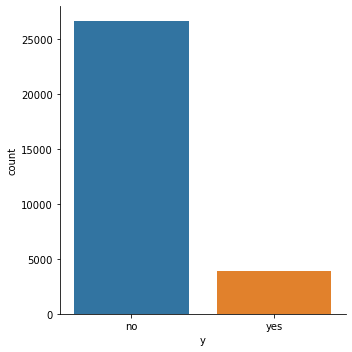

In [8]:
sns.catplot(x='y', data = bankData2, kind = 'count')

Text(0.5, 1.0, 'Marital Distribution')

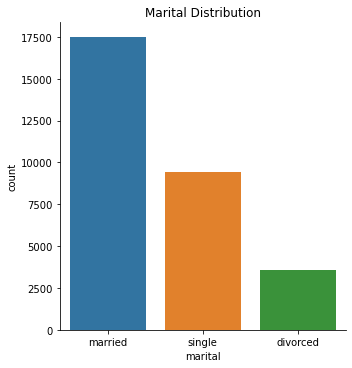

In [9]:
sns.catplot(x='marital', kind = 'count', data = bankData2)
plt.title('Marital Distribution')

A boxplot of the duration variable showed that the majority of the data were outliers and would not contribute significantly to modeling. In addition, the outliers could potentially bias the overall model leading to unrealistic outcomes. 

<AxesSubplot:xlabel='duration'>

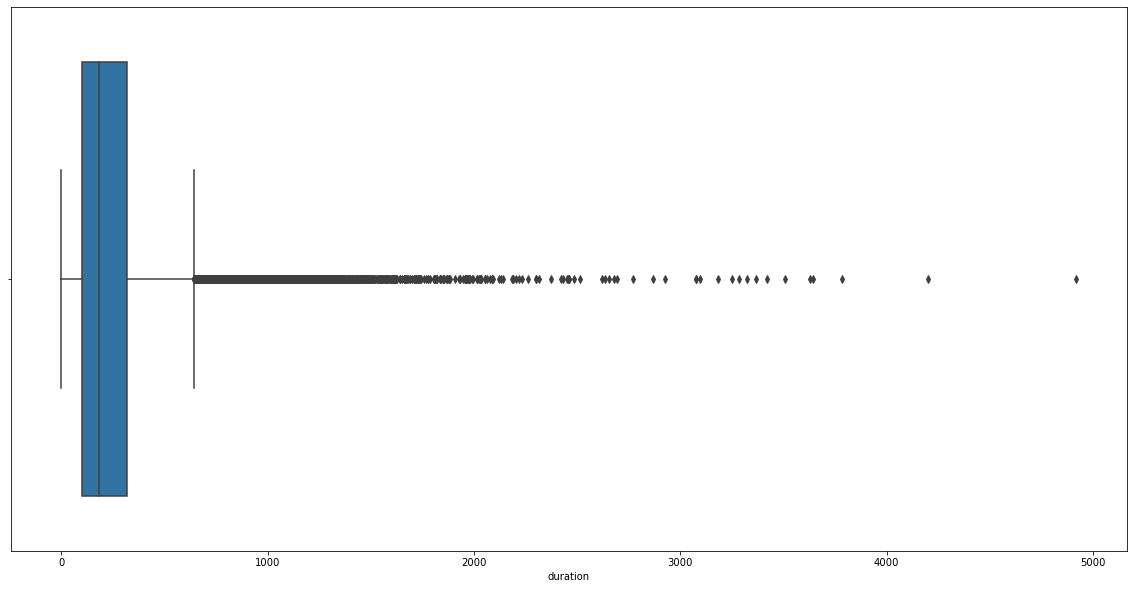

In [10]:
sns.boxplot(x=bankData["duration"])

Before we could build a model, we needed to create a dataframe with the target variable, y, which was whether a customer decided to take on a long term deposit.

In [11]:
#Define the target variable
y = bankData2.y
y.head()

0    no
2    no
3    no
4    no
6    no
Name: y, dtype: object

The dataset is a mixture of both continuous, numeric, and categorical data, therefore we chose to separate the categorical attributes into a separate dataframe and apply One Hot Encoding to convert categorical entries to numeric data. The converted dataframe was concatenated back into the original dataframe and the original attributes were removed.

In [12]:
#One hot encoding of ALL categorical variables

# pd.concat([*]], axis=1) // this line of code concatenates all the data frames in the [*] list
# [** for col in categ_features] // this steps through each feature in categ_features and 
#                                //   creates a new element in a list based on the output of **
# pd.get_dummies(df_imputed[col],prefix=col) // this creates a one hot encoded dataframe of the variable=col (like code above)

categ_features = ['job','marital','education','default','housing','loan','contact','month','poutcome'];

OneHotDF = pd.concat([pd.get_dummies(bankData2[col],prefix=col,drop_first=True) for col in categ_features], axis=1)

OneHotDF.head()

#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/01.%20Pandas.ipynb

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## Data Preparation Part 2

*Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).*

We did not create any new variables....
I think we should remove duration and default

# Creating and Adjusting Models

**Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use
80/20 training/testing split for your data). Adjust parameters of the models to make them more
accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel
only is fine to use.**

## Logistic Regression

Before building the models, we first separated out the Features and the Target for establishing testing and training sets. 

In [13]:
#Separating out the features for training and testing
X = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1)
X = X.values

#Separating out target for training and testing
Y = bankData2.pop("y")
Y = Y.values.ravel()


Once the features were separated, we performed hold out cross validation with 3 splits using a basic Logistic Regression model. We then compared accuracies between iterations of cross validation performed on the test and training splits. The random state was set to 1 for replicability.

In [14]:
#Cross validation, using 80/20 train/test splitting
splits = 3
randomState=1
cv = ShuffleSplit(n_splits=splits, test_size=0.20, random_state=randomState)

#Creating standard scaler object
scl_obj = StandardScaler()

#Creating Logistic Regression object
lr_clf = LogisticRegression(random_state=randomState)

#Setting Iteration start point for for loop
iter_num=1

#For loop for creating testing and training sets and running a full basic LR model to
#Compare iterations the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv.split(X,Y): 
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    
    X_test = X[test_indices]
    Y_test = Y[test_indices] 
    
    X_train_scaled = scl_obj.fit_transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 
    
    lr_clf.fit(X_train_scaled, Y_train)  # train object
    y_hat = lr_clf.predict(X_test_scaled) # get test set predi0ctions
    acc = mt.accuracy_score(Y_test,y_hat)
    conf = mt.confusion_matrix(Y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print('accuracy:', acc )
    print("confusion matrix\n",conf)
    #print(conf)
    iter_num+=1
    
#Also note that every time you run the above code
#it randomly creates a new training and testing set, 
#so accuracy will be different each time
    

#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb


====Iteration 1  ====
accuracy: 0.9022630370613316
confusion matrix
 [[5172  164]
 [ 432  330]]
====Iteration 2  ====
accuracy: 0.9050508363397836
confusion matrix
 [[5188  157]
 [ 422  331]]
====Iteration 3  ====
accuracy: 0.8934076746474254
confusion matrix
 [[5099  170]
 [ 480  349]]


We can see from above that the resulting models tended to hover around 90% accuracy. The next step was for us to hyper tune the parameters of our logistic regression model using the following interactive code. Accuracy values will vary from above due to slight differences the training and test sets generated from the hold out cross validation. Our focus is on what changes to parameters improve the general model, so these small differences do not have an impact.

In [15]:
#Here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def exploreLogisticRegression(penMethod, cost, algorithm, maxIterations, dualOption, fiOption, iScaling,  tolerance):
    model = LogisticRegression(random_state=randomState,
                               penalty='l2',
                               C=cost,
                               solver=algorithm,
                               max_iter = maxIterations,
                               dual = dualOption,
                               fit_intercept = fiOption,
                               intercept_scaling = iScaling,
                               tol = tolerance * 1e-4)
    acc = cross_val_score(model,X,y=y,cv=cv)
    print("\n\nUsing the settings above, the accuracy is",acc[0])

print('Logistic Regression Parameter Tuning:')
#Default values:
#PenMethod = l2, cost = 1, algorithm = lbfgs, maxIterations = 100
#verboseN = 0, dualOption = False, tolerance = 1e-4 or 1 on the sliders,
#
wd.interact(exploreLogisticRegression,
            penMethod=['l2','l1','elasticnet', 'none'],
            cost=(0.001,5,0.05),
            algorithm = ['liblinear', 'saga', 'sag', 'newton-cg', 'lbfgs'],
            maxIterations = (50,500,10),
            dualOption = [False, True],
            fiOption = [True,False],
            iScaling = (1,20,1),
            tolerance = (1,10,1),
            __manual=True)

Logistic Regression Parameter Tuning:


interactive(children=(Dropdown(description='penMethod', options=('l2', 'l1', 'elasticnet', 'none'), value='l2'…

<function __main__.exploreLogisticRegression(penMethod, cost, algorithm, maxIterations, dualOption, fiOption, iScaling, tolerance)>

From our fine tuning above, we found that the only parameter that seemed to noticably affect our model was the C parameter, which is the value of the inverse of the regularization strength. The higher the C value, the less regularization is applied to reduce generalization errors opposed to training errors.

The best C value for this model is 0.30000000000000004


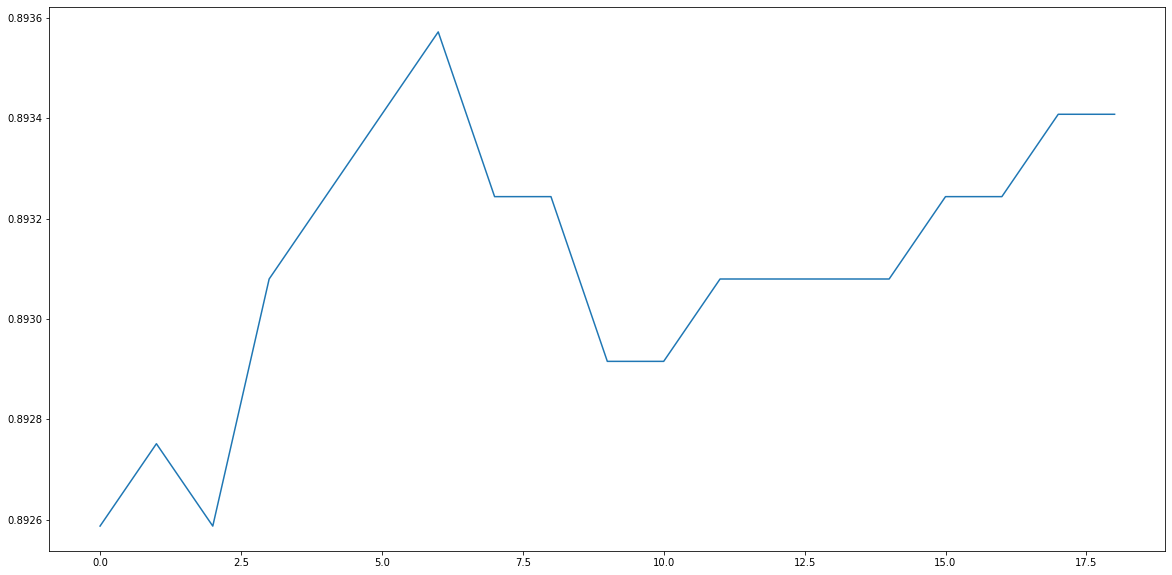

In [16]:
accs = []
for i in range(1,20):
    model = LogisticRegression(C=i * .05, solver = 'liblinear')
    model.fit(X_train_scaled, Y_train)
    preds = model.predict(X_test_scaled)
    accs.append(mt.accuracy_score(Y_test,preds))

accs = pd.Series(accs)
accs.plot()
print('The best C value for this model is', accs.idxmax() * .05)

From our resulting plot above, we can see that the optimal value for C is about .3. Once our model was tuned, we constructed a full model to generate the accuracy and confusion matrix.

In [17]:
%%time
finalModel = LogisticRegression(penalty='l2', C=0.3, solver='liblinear')
finalModel.fit(X_train_scaled,Y_train)
preds = finalModel.predict(X_test_scaled)
lrAcc = mt.accuracy_score(Y_test,preds)
conf = mt.confusion_matrix(Y_test,preds)
print('accuracy:', lrAcc )
print("Confusion Matrix:\n",conf,"\n")

accuracy: 0.8934076746474254
Confusion Matrix:
 [[5100  169]
 [ 481  348]] 

CPU times: total: 453 ms
Wall time: 409 ms


We obtained an overal accuracy score of 89.34% and it took approximately half a second to run (.445 ms).

## Support Vector Machines

After obtaining our final Logistic Regression model, we constructed a SVM model using the SVC object from Scikit-learn. Our dataset was already scaled from our previous model, so we did not need to do any further transformations to our dataset befor constructing the model. Because our training set contained a small number of predictors but a larger size of individual obersvations (43x24390), we chose to use a linear kernal approach to building the model.

In [18]:
%%time
#Training the model
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto')
svm_clf.fit(X_train_scaled, Y_train)

#Generating Predictions
y_hatSVM = svm_clf.predict(X_test_scaled)

#Calculating accuracy and confusion matrix and printing the two
svmAcc = mt.accuracy_score(Y_test,y_hatSVM)
conf = mt.confusion_matrix(Y_test,y_hatSVM)

CPU times: total: 17.3 s
Wall time: 17.1 s


In [19]:
#Printing information above
print('accuracy:', svmAcc )
print("Confusion Matrix:\n",conf,"\n")

accuracy: 0.8848802886192194
Confusion Matrix:
 [[5121  148]
 [ 554  275]] 



From our initial SVM model, we obtained an accuracy score of 88.49% and it took 14.7 seconds to generate. With this in mind, we attempted to make improvements to the model. We attempted to make adjustments to the parameters within the model object to raise our accuracy, but no matter what approach we took, our accuracy would not improve. However, we did find that as we decreased the C parameter, the performance time of the model improved with minimal loss in accuracy. C is proportional to the inverse of the regulization of the model, and therefore as we decrease C, the regularity of the model increases. We can expect an increase in regularity to decrease the performance time as well as the model is essentially limiting itself from overfitting the model. 

The next four cells present models with different C values that vary in decreasing magnitude. Using the python time function, we calculated the time to execute each model. 

In [20]:
%%time 
model = SVC(C=.5, kernel = 'linear', degree=3, gamma='auto')
model.fit(X_train_scaled, Y_train)
preds = model.predict(X_test_scaled)
mt.accuracy_score(Y_test,preds)

CPU times: total: 15.8 s
Wall time: 15.9 s


0.8848802886192194

In [21]:
%%time 
model = SVC(C=.05, kernel = 'linear', degree=3, gamma='auto')
model.fit(X_train_scaled, Y_train)
preds = model.predict(X_test_scaled)
mt.accuracy_score(Y_test,preds)

CPU times: total: 12.3 s
Wall time: 12.9 s


0.8847163004263693

In [22]:
%%time 
model = SVC(C=.005, kernel = 'linear', degree=3, gamma='auto')
model.fit(X_train_scaled, Y_train)
preds = model.predict(X_test_scaled)
mt.accuracy_score(Y_test,preds)

CPU times: total: 11.9 s
Wall time: 12.5 s


0.881436536569367

In [23]:
%%time 
model = SVC(C=.001, kernel = 'linear', degree=3, gamma='auto')
model.fit(X_train_scaled, Y_train)
preds = model.predict(X_test_scaled)
mt.accuracy_score(Y_test,preds)

CPU times: total: 9.81 s
Wall time: 9.96 s


0.8788127254837652

From the results, we can see that our performance time nearly halved while our accuracy suffered by less than 1%.

## Gradient Based Alternatives

The group discussed the option of using the stochastic gradient descent (SGD) model technique. However, it was determined that since the data set in this analysis is relatively small, having only 44 features and around 32,000 entries and the run times of our models were not extensive, using the SGD optimizer did not seem like a critical model to perform.

# Discussing Advantages

**Discuss the advantages of each model for each classification task. Does one type
of model offer superior performance over another in terms of prediction accuracy? In terms of
training time or efficiency? Explain in detail.**

In [24]:
#Converting target to binary for log loss score
yBinary = pd.Series(np.where(Y == 'yes', 1, 0),y.index)

#Converting predictions to binary for log loss score
yhatSVMBinary = pd.Series(np.where(y_hatSVM == 'yes', 1, 0))
yhatLRBinary = pd.Series(np.where(preds == 'yes', 1, 0))

#Calculating log loss scores for both models displayed above
logLossSVM = log_loss(Y[test_indices],yhatSVMBinary)
logLossLR = log_loss(Y[test_indices],yhatLRBinary)
print('The Log Loss of the logistic regression model is: ', logLossLR)
print('The Log Loss of the SVM model is: ', logLossSVM)
#Displaying percent difference between the two scores
percDif = str(round(abs((logLossLR - logLossSVM)/logLossLR)*100,2))
print('The difference between the two scores is',percDif,'%')

#Printing out accuracies of both models
print('\nThe Accuracy of the logistic regression model is: ', lrAcc)
print('The Accuracy of the SVM model is: ', svmAcc)

The Log Loss of the logistic regression model is:  4.185674862373103
The Log Loss of the SVM model is:  3.9761133764589984
The difference between the two scores is 5.01 %

The Accuracy of the logistic regression model is:  0.8934076746474254
The Accuracy of the SVM model is:  0.8848802886192194


When it comes to log-loss scores, the model with the lower score is superior. Log loss is an indication of how close the prediction probability is to the actual value. As the probability diverges from the actual value, the log loss score increases. With this logic, we can see that the logistic regression model performs better by less than 5% (3.68159 < 3.84586) when it comes to full models. We also consistently obtained slightly higher accuracy scores through logistic regression (89.3% vs 88.4%). In terms of performance, we also saw advantages to the logistic regression model. Our logistic regression model took less than a second to run while we saw performance times as low as 8 seconds with the SVM model. With this in mind, we suggest the application of a logistic regression model over a SVM model for this specific classification problem.

This makes practical sense as both models are utilizing the dataset that is one hot encoded to remove classiciation type predictors. If we were to compare the two models using the non-encoded data set, we would have expected the SVM model to display a better Log Loss score because SVM models are ideal for multiclass approaches to classification. The dataset utilized in these models is already structured with identified independent variables and SVM is known to perform better on data sets that are less structured, so there is further evidence to suggest that our dataset is better utilized through a logistic regression model. 

It is important to note that while we saw slightly better performance in our logistic regression model, SVM models are less likely to overfit. However, this overfitting may be significantly decreased through adjustments of the C parameter.

**Reference: https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16#:~:text=SVM%20works%20well%20with%20unstructured,is%20based%20on%20statistical%20approaches.**

# Interpretting weights

**Use the weights from logistic regression to interpret the importance of different
features for each classification task. Explain your interpretation in detail. Why do you think
some variables are more important?**

The following is a breakdown of the coefficient weights:

emp.var.rate has weight of 2.3272868381667786
duration has weight of 1.1883478634200197
cons.price.idx has weight of 1.0397988024688538
euribor3m has weight of 0.46414853754237906
month_aug has weight of 0.2689304553423485
contact_telephone has weight of 0.2654136892290153
month_mar has weight of 0.2354971341114513
pdays has weight of 0.19618688355282693
month_may has weight of 0.19598487202256573
poutcome_success has weight of 0.1736642156750413
nr.employed has weight of 0.15815695796185744
poutcome_nonexistent has weight of 0.14348948546292886
campaign has weight of 0.12211578530876782
month_nov has weight of 0.11002809357832154
month_jun has weight of 0.10933584556726088
education_university.degree has weight of 0.1047062116913958
job_services has weight of 0.07608483554276488
job_blue-collar has weight of 0.07447443073955393
job_retired has weight of 0.07176795625349823
cons.conf.idx has weight of 0.06660013851551537
educati

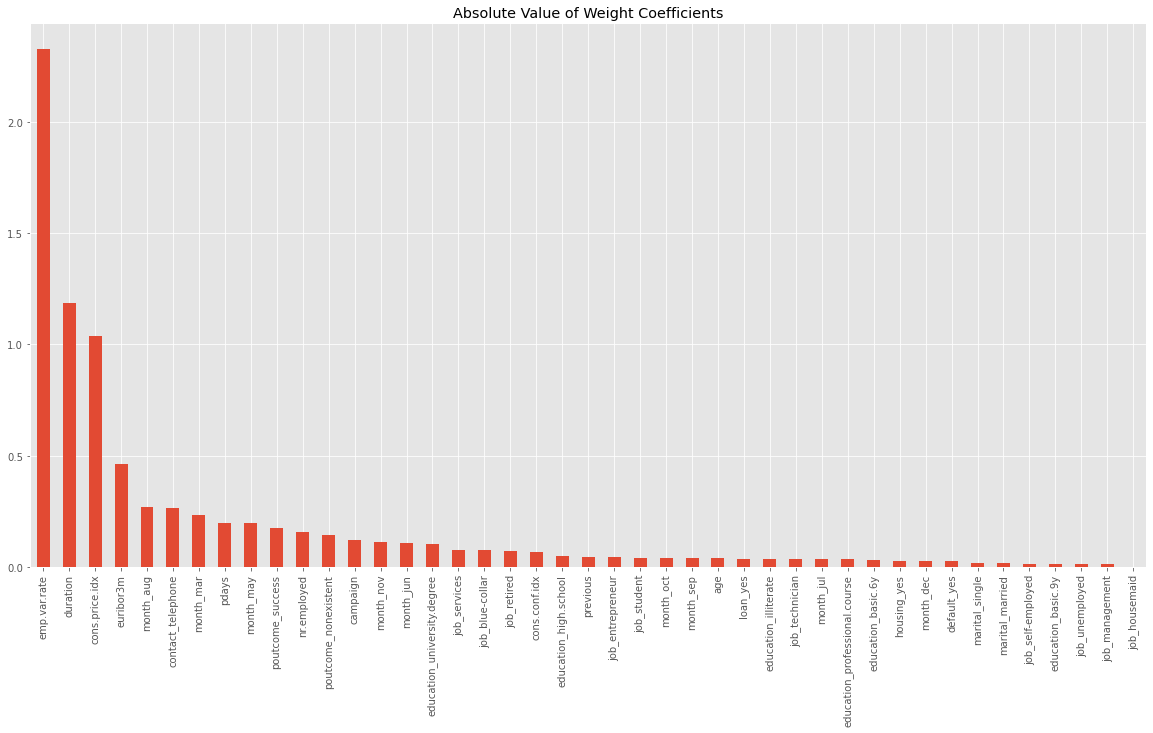

In [25]:
#Printing weights on a normalized scale
print('The following is a breakdown of the coefficient weights:\n')
#Sort these attributes and spit them out
zip_vars = zip(abs(finalModel.coef_.T),pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1).columns) # combine attributes
zip_vars = sorted(zip_vars, reverse=True)

for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
#Plot magnitude of weights in descending order
#Grabbing column names for labels
#columns = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=0).columns

%matplotlib inline
plt.style.use('ggplot')

#Set Figure Size
plt.rcParams["figure.figsize"] = (20,10)

#Plotting weights
labels = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1).columns
weights = abs(pd.Series(finalModel.coef_[0],index=labels)).sort_values(ascending=False)
weights.plot(kind='bar', title="Absolute Value of Weight Coefficients")
plt.show()

From the plot above, we can visually determine that there are only 3 features that have a magnitude weight above 1: emp.var.rate, duration, and cons.price.idx. Of these three variables, emp.var.rate and cons.price.idx are variables that do not vary between different people. Instead they are statistics that are updated every quarter. the euribor3m variable also shares this characteristic, although it is an international statistic that measures the interest rates of European banks. While these variables may present some inbalance to the model, they also present evidence that the likelyhood of a client subscribing to a term deposit may depend heavily on the socio-economic status of the country as well as the length the campaign to get the client to subscribe. 

With heavier weights on variables that are more time dependent as displayed above, there evidence that a time series model could actually perform better for this specific classification problem. Furthermore, variables such as month_aug and month_mar are one hot encoded variables that denote the time of month of the last point of contact. This is further evidence to suggest that a time series model may be appropriate for this kind of classification problem With this information we would fully suggest that term deposit subscription rate be investigated in a time series setting in addition to using classification. 

The other variable that has a weight above 1 is duration. This variable denotes the length of the point of last contact with the prospect subscriber. This variable could not be practically used to predict whether a new client will subscribe to a term deposit because one should expect the length of the call to be longer for those customers who decided to opt for the bank term deposit, while those who did not take out a deposit would not stay on the call for as long; therefore, the duration has a direct effect on the outcome of the model but is not a beneficial attribute for creating accurate predictions. However, it can be used as evidence to suggest that the longer you are in contact with a prospective client, the more likely they are to subscribe.

In terms of interesting observations, one thing we noticed was how people who were contacted via a non-cellular phone were more likely to subscribe to a term deposit. We also observed a higher chance of a person subscribing if they graduated with a university degree or worked in blue collar or service jobs, however the significance to the model for all of these variables is minor with coefficient values less than .5.

# SVM Vectors Investigation

**Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain.**

We decided to investigate our SVM vectors generated by the SVC package through kernal density estimate plots. We generated plots for both the original dataset and the dataset with the selected indices that were used by the support vectors before making comparisons. In addition to this, we also displayed the shape, indices, and numbers of vectors.

C:\Users\chris\AppData\Local\Temp\ipykernel_8444\1164991864.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankData2["y"] = Y # also add it back in for the original data


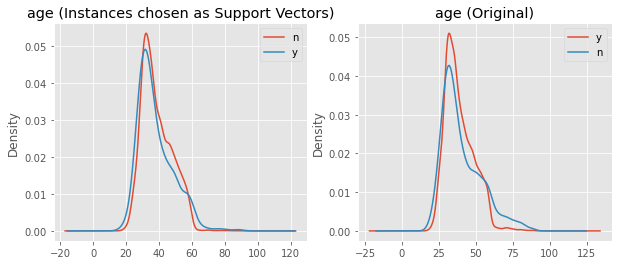

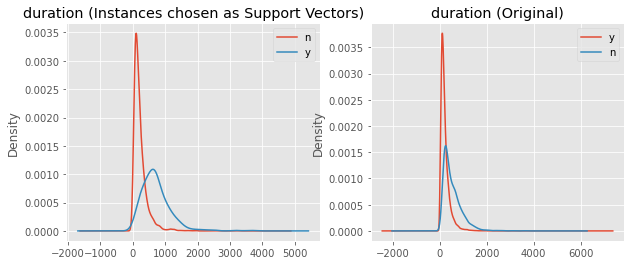

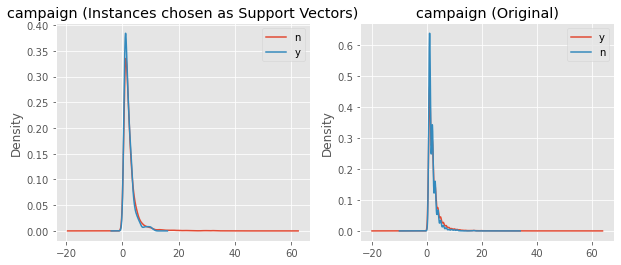

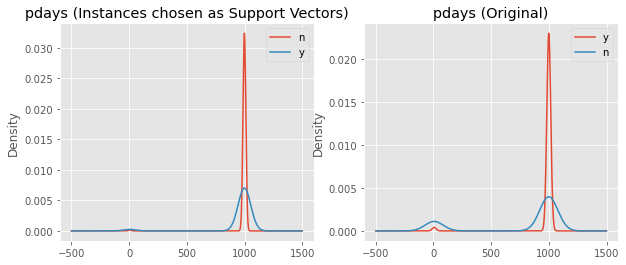

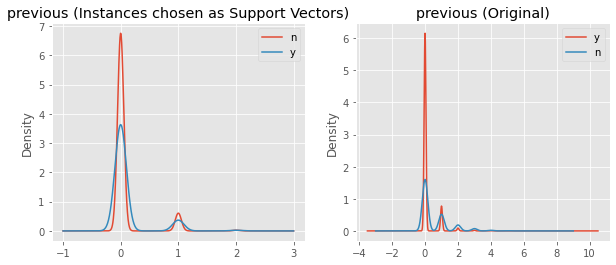

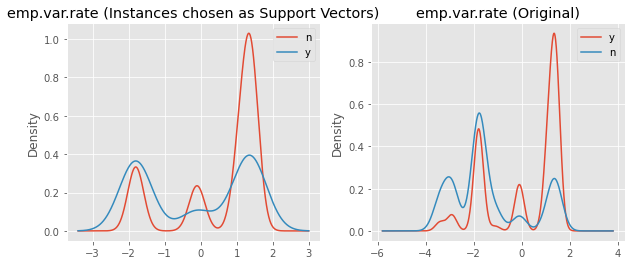

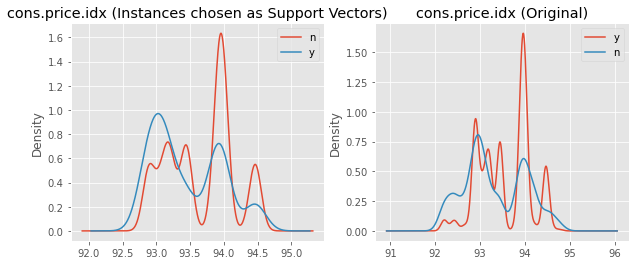

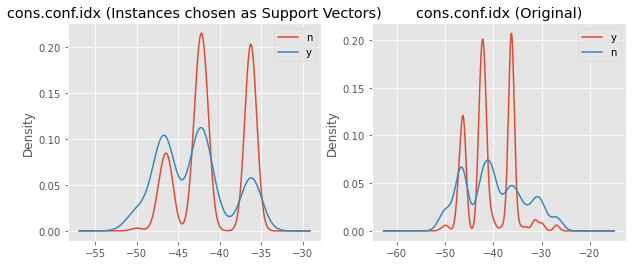

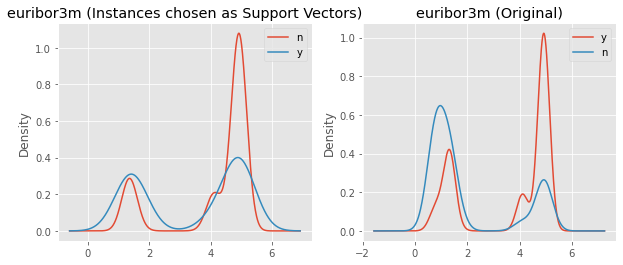

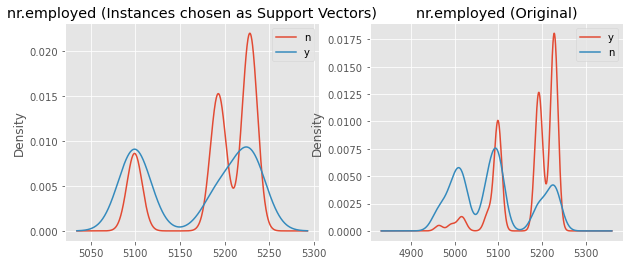

In [26]:
#Make a dataframe of the training data
df_tested_on = bankData2.iloc[train_indices].copy()

#Getting the support vectors from the trained model
df_support = bankData2.iloc[svm_clf.support_,:].copy()

#Adding y column back into datasets
df_support["y"] = Y[svm_clf.support_] 
bankData2["y"] = Y # also add it back in for the original data

#Group the original data and the support vectors
df_grouped_support = df_support.groupby(["y"])
df_grouped = bankData2.groupby(["y"])

#Plotting Kernal Density Estimates of all continuous variables
for v in bankData[conCol].columns:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(["n","y"])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['y','n'])
    plt.title(v+' (Original)')
    


In [27]:
#Printing Support Vector shapes and information
print("The shape of the support vectors is ",svm_clf.support_vectors_.shape)
print("The indices of support vectors are",svm_clf.support_.shape)
print("The numbers of support vectors for each class are",svm_clf.n_support_, "\n")

The shape of the support vectors is  (5351, 43)
The indices of support vectors are (5351,)
The numbers of support vectors for each class are [2684 2667] 



The chosen support vectors appear to generally show less separation relative to the original data set. This is because the support vectors will usually select data points on the edge of the class boundaries. However, for certain features, like age, the change in separation is a more difficult to notice. Having performed a detailed EDA in the last lab, we believe less change in separation is likely due to the similarity in distributions between the features and the response classes. Looking at the features that are showing a more drastic change in separation, like nr.employed (number of employees), we see that density plot distributions and peaks are fairly similar and track each other to some degree. This is to be expected because the support vector distributions should reflect the population from which they are being pulled from and again, because the support vector instances are typically on the edge of the class boundaries, the response class density distributions will inevitably be more similar.

## Start Project 2

In [28]:
Y = pd.get_dummies(bankData2["y"],prefix="y", drop_first=True)
Y = Y.values.ravel()

In [29]:
X.shape

(30488, 43)

In [30]:
X

array([[ 56., 261.,   1., ...,   0.,   1.,   0.],
       [ 37., 226.,   1., ...,   0.,   1.,   0.],
       [ 40., 151.,   1., ...,   0.,   1.,   0.],
       ...,
       [ 56., 189.,   2., ...,   0.,   1.,   0.],
       [ 44., 442.,   1., ...,   0.,   1.,   0.],
       [ 74., 239.,   3., ...,   0.,   0.,   0.]])

In [31]:
%%time
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# # create variables we are more familiar with
yhat = np.zeros(Y.shape) # we will fill this with predictions

scl = StandardScaler()
X = scl.fit_transform(X)

# # setup pipeline to take PCA, then fit a KNN classifier
# ## Randomized used to run faster
# clf_pipe = Pipeline(
#     [('PCA_Eric',PCA(n_components=43,svd_solver='randomized'))]
# )

clf_pipe = Pipeline(
    [('PCA_Eric',PCA(n_components=43,svd_solver='randomized')),
     ('CLF_Eric',KNeighborsClassifier(n_neighbors=1))]
)

# # now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,Y):
    clf_pipe.fit(X[train],Y[train])
    yhat[test] = clf_pipe.predict(X[test])
    


total_accuracy = mt.accuracy_score(Y, yhat)
print ('KNN, pipeline accuracy', total_accuracy)

KNN, pipeline accuracy 0.867456048281291
CPU times: total: 16.5 s
Wall time: 9.8 s


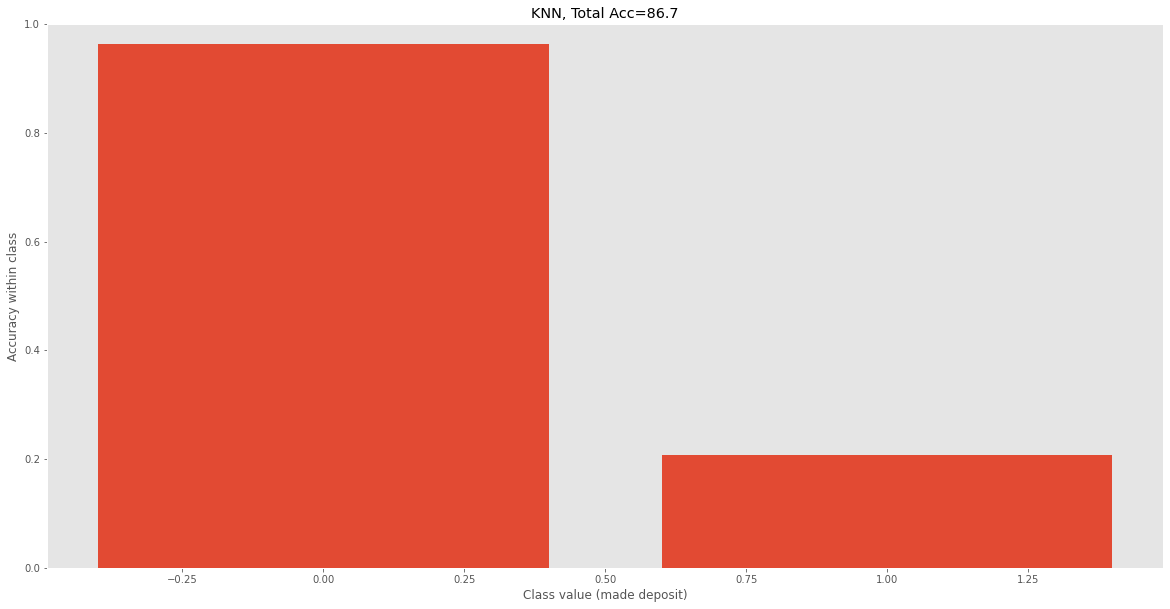

array([0.96319802, 0.20678932])

In [32]:
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (made deposit)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
    

plot_class_acc(Y,yhat,title="KNN")

per_class_accuracy(Y,yhat)    



Pipeline accuracy 0.8817567567567568


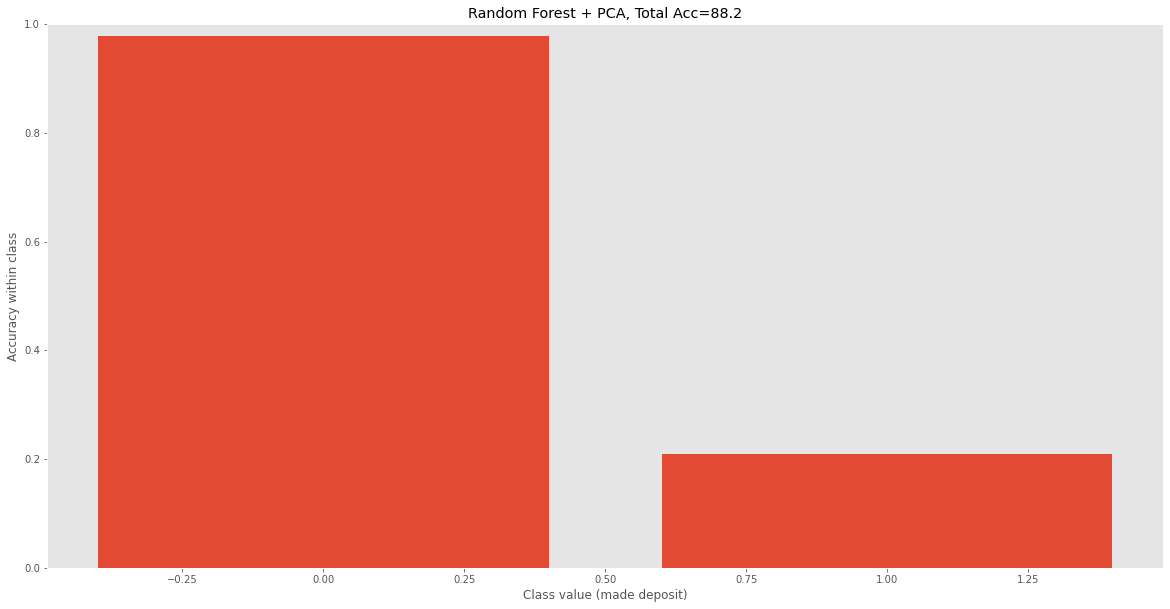

Pipeline accuracy 0.8827407504591971


In [35]:
# %%time
from sklearn.ensemble import RandomForestClassifier
 
clf_pipe = Pipeline(
    [('PCA',PCA(n_components=43, svd_solver='randomized')),
     ('CLF',RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,Y):
    clf_pipe.fit(X[train],Y[train])
    yhat[test] = clf_pipe.predict(X[test])
    
total_accuracy = mt.accuracy_score(Y, yhat)
print ('Pipeline accuracy', total_accuracy)
plot_class_acc(Y,yhat,title="Random Forest + PCA")

# added yhat_score for ROC curve
yhat_score = np.zeros((y.shape[0],2))

# now iterate through and get predictions, saved to the correct row in yhat
## predict_proba  returns a vector 
for train, test in cv.split(X,Y):
    clf_pipe.fit(X[train],Y[train])
    yhat[test] = clf_pipe.predict(X[test])
    yhat_score[test] = clf_pipe.predict_proba(X[test])

total_accuracy = mt.accuracy_score(Y, yhat)
print ('Pipeline accuracy', total_accuracy)

In [36]:
yhat_score 

array([[0., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [37]:
Y

array([0, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [42]:
y

0         no
2         no
3         no
4         no
6         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 30488, dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{0: 0.6002005803526581, 1: 0.6466806023913028}


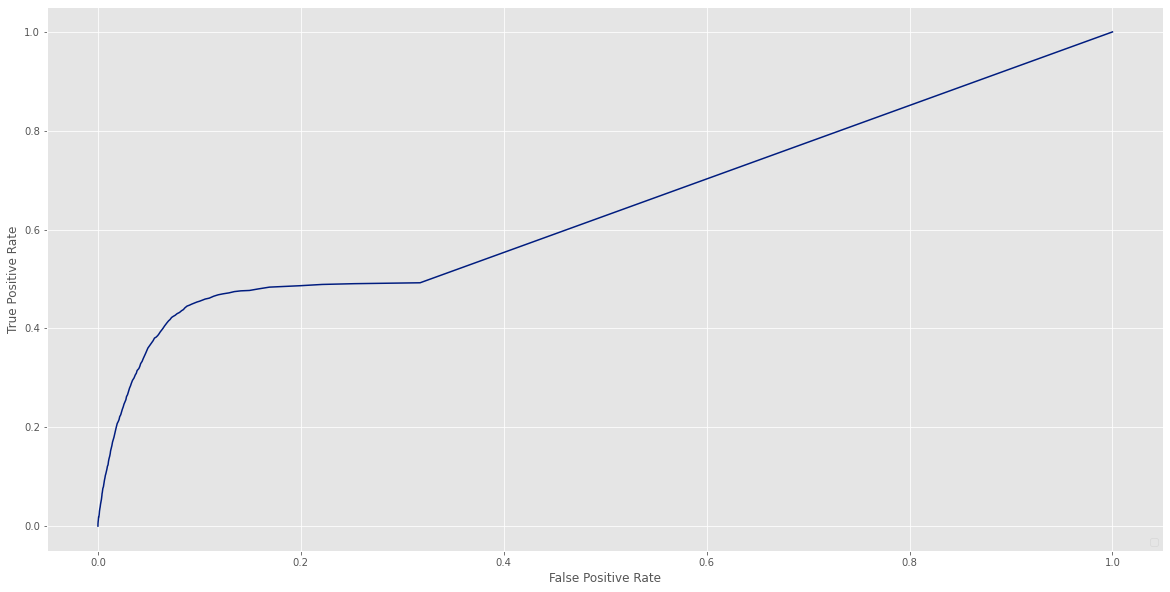

In [38]:
import seaborn as sns
sns.set_palette("dark")
# code manipulated from http://scikit-learn.org/stable/auto_examples/plot_roc.html
from sklearn.preprocessing import label_binarize

# Compute ROC curve for a subset of interesting classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in np.unique(Y):
    fpr[i], tpr[i], _ = mt.roc_curve(Y, yhat_score[:, i], pos_label=i)
    roc_auc[i] = mt.auc(fpr[i], tpr[i])
    

print(roc_auc)

plt.plot(fpr[1], tpr[1])


plt.legend(loc="lower right")  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
    

Accuracy 0.8862503279979008


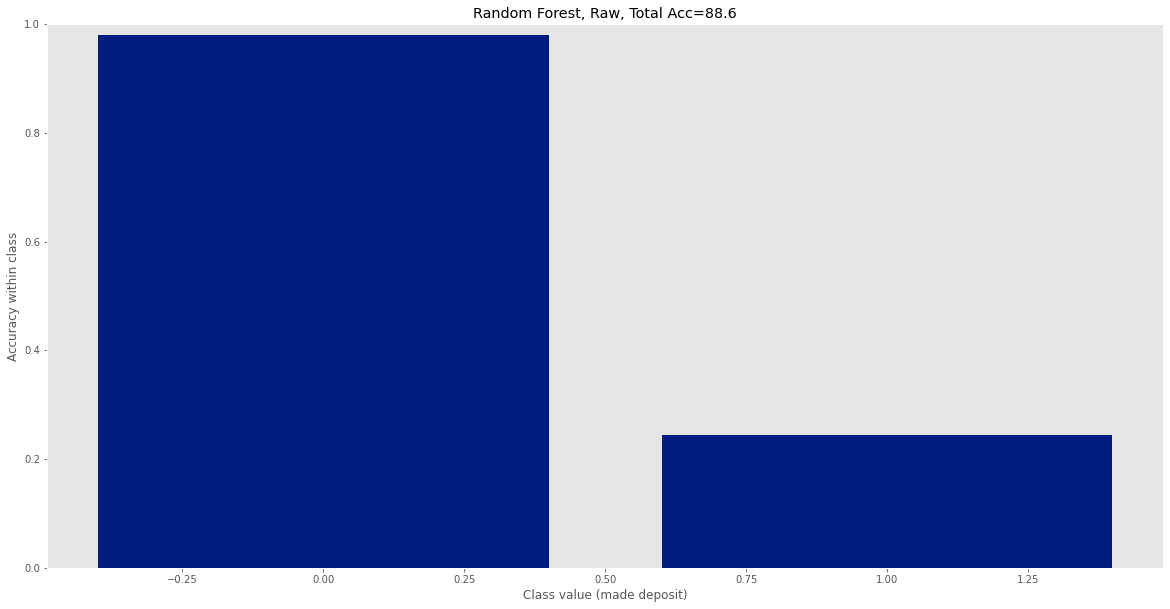

Pipeline accuracy 0.8826095512988716
CPU times: total: 2min 1s
Wall time: 20.3 s


In [39]:
%%time
from sklearn.ensemble import RandomForestClassifier
## Out of bag score, unique to random forest, will take leftover records and feed them through
## model and score them 
clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,Y):
    clf.fit(X[train],Y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(Y, yhat)
print ('Accuracy', total_accuracy)
plot_class_acc(Y,yhat,title="Random Forest, Raw")


# added yhat_score for ROC curve
yhat_score = np.zeros((y.shape[0],2))

# now iterate through and get predictions, saved to the correct row in yhat
## predict_proba  returns a vector 
for train, test in cv.split(X,Y):
    clf_pipe.fit(X[train],Y[train])
    yhat[test] = clf_pipe.predict(X[test])
    yhat_score[test] = clf_pipe.predict_proba(X[test])

total_accuracy = mt.accuracy_score(Y, yhat)
print ('Pipeline accuracy', total_accuracy)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{0: 0.6001020267248245, 1: 0.6469541586521799}


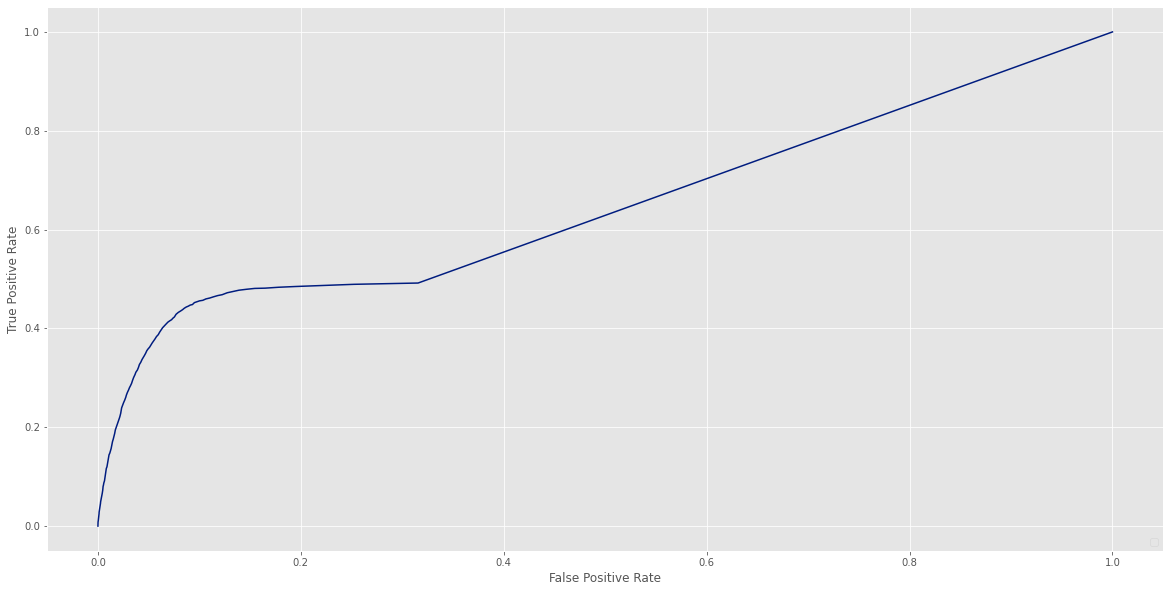

In [40]:
import seaborn as sns
sns.set_palette("dark")
# code manipulated from http://scikit-learn.org/stable/auto_examples/plot_roc.html
from sklearn.preprocessing import label_binarize

# Compute ROC curve for a subset of interesting classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in np.unique(Y):
    fpr[i], tpr[i], _ = mt.roc_curve(Y, yhat_score[:, i], pos_label=i)
    roc_auc[i] = mt.auc(fpr[i], tpr[i])
    
    

print(roc_auc)

plt.plot(fpr[1], tpr[1])

plt.legend(loc="lower right")  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# now lets get access to the different properties of our RF

print (clf)

plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

print ('Generalization score estimate from training data', clf.oob_score_)

# Most importatn variable is duration
# X_View = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1)
# X_View.head()


In [ ]:
##Tree Ensemble Comparisons

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score

num_estimators = 50
# lets train some trees
clf_array = [
    ('Stump',              DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)),
    ('Tree',               DecisionTreeClassifier()),
    ('Random Trees',       RandomForestClassifier(max_depth=50, n_estimators=num_estimators)),
    ('Extra Random Trees', ExtraTreesClassifier(n_estimators=num_estimators,min_samples_split=2)),
    ('Boosted Tree',       GradientBoostingClassifier(n_estimators=num_estimators)), #takes a long time
    ]

for clf in clf_array:
    acc = cross_val_score(clf[1],X,y,cv=3)
    print (clf[0], acc.mean())

In [ ]:
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB


# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',PCA(n_components=43,svd_solver='randomized')),
     ('CLF',GaussianNB())]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,Y):
    clf_pipe.fit(X[train],Y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(Y, yhat)
print ('Pipeline accuracy', total_accuracy)
plot_class_acc(Y,yhat,title="Naive Bayes + PCA")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pipeline accuracy 0.8830359485699292
{0: 0.6001963375107193, 1: 0.6475800313602462}


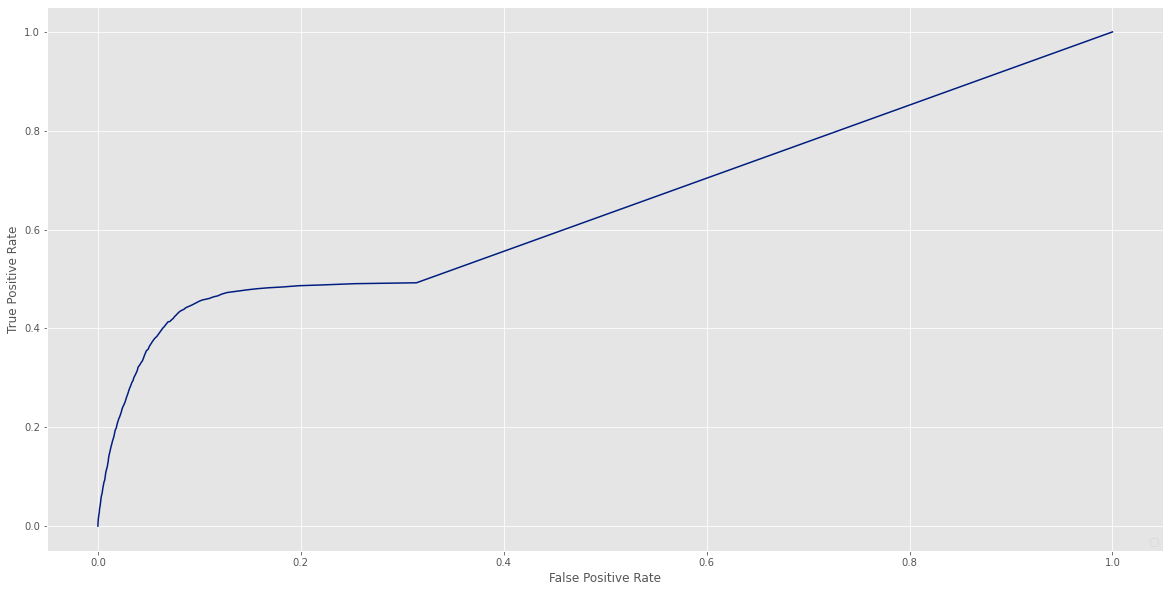

In [41]:
# added yhat_score for ROC curve
yhat_score = np.zeros((Y.shape[0],2))

# now iterate through and get predictions, saved to the correct row in yhat
## predict_proba  returns a vector 
for train, test in cv.split(X,Y):
    clf_pipe.fit(X[train],Y[train])
    yhat[test] = clf_pipe.predict(X[test])
    yhat_score[test] = clf_pipe.predict_proba(X[test])

total_accuracy = mt.accuracy_score(Y, yhat)
print ('Pipeline accuracy', total_accuracy)

# Compute ROC curve for a subset of interesting classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in np.unique(Y):
    fpr[i], tpr[i], _ = mt.roc_curve(Y, yhat_score[:, i], pos_label=i)
    roc_auc[i] = mt.auc(fpr[i], tpr[i])
    
    

print(roc_auc)

plt.plot(fpr[1], tpr[1])

plt.legend(loc="lower right")  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# May not use this as is frequency

from sklearn import metrics as mt

y = Y

freq_infreq_threshold = 40

# get various measures of performance
total_accuracy = mt.accuracy_score(y, yhat)
per_class_acc_list = per_class_accuracy(y,yhat)

prec_for_freq_classes = []
recall_for_infreq_classes = []
rec_tot = []
prec_tot = []

for cls in np.unique(y):
    idx = (y==cls) # get classes
    ytmp_actual = np.zeros(y.shape) # make binary class problem
    ytmp_actual[idx] = 1 # set the instances for this specific class
    
    ytmp_predicted = np.zeros(y.shape) # binary prediction array
    ytmp_predicted[yhat==cls] = 1
    
    num_in_class = sum(idx)
    
    rec = mt.recall_score(ytmp_actual, ytmp_predicted)
    prec = mt.precision_score(ytmp_actual, ytmp_predicted)
    rec_tot.append(rec)
    prec_tot.append(prec)
    
    if num_in_class < freq_infreq_threshold:
        recall_for_infreq_classes.append(rec)
    elif num_in_class >= freq_infreq_threshold:
        prec_for_freq_classes.append(prec)
        

## Need to change titles, uses frequency        
print ('Total Accuracy:',total_accuracy)
print ('Number of infrequent faces:',len(recall_for_infreq_classes), 
       'with average recall of:', np.mean(recall_for_infreq_classes))
print ('Number of frequent faces:',len(prec_for_freq_classes), 
       'with average precision of:',np.mean(prec_for_freq_classes))